In [1]:
# Loading the dataset suzuki_data.csv with dimensions: 5252x14
# Stock price data of Pak Suzuki Motor Company Limited (Pakistan)
# Stock prices daily data from 01 Jan 2001 to 17 Nov 2022 

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv('suzuki_data.csv')

## Setting Hyperparameters
MAX_epochs = 20        # Maximum number of epochs
tol = 0.000001         # Tolerance
alpha = 0.01           # Learning rate
m = 50                # Number of instances in a minibatch
window_size = 10

train_test_ratio = 0.95
train_validation_ratio = 0.8

# Setting Layers and Number of neurons in each layer
ldim = [window_size, 20, 30, 10, 5, 1]
L = len(ldim) - 1    # Number of layers (other than the input layer)

ldim = np.array(ldim, dtype=int)
np.random.seed(1)

print("Original Dataset Head:")
print(df.head())

print("Original Dataset Tail:")
print(df.tail(5))

# Loading and making the data ready in desired format

df = df.dropna()                # data cleaning as desired

# Selecting the relevant column for training and prediction
df_main = df['Close']
df_main = np.array(df_main).reshape(-1,1)

# normalizing the data between 0 to 1
normalizing = MinMaxScaler(feature_range=(0,1))
normalized_data = normalizing.fit_transform(df_main)

## Spliting the time series data into train and test sets
## Temporal order of the data is preserved

train_size = int(len(normalized_data) * train_test_ratio)
train_data = normalized_data[:train_size]
test_data  = normalized_data[train_size:]

# Function for creating datasets using Sliding Window Technique
# This is a common technique for time series prediction using FNN
# Slider window size is the time step

def dataset_creator(window_size, data):
    X, Y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        Y.append(data[i, 0])
    return np.array(X), np.array(Y)



train_validation_ratio = 0.8  # Adjust split ratio 

# Calculate the split index based on the ratio
splitter = int(len(train_data) * train_validation_ratio)

# Creating the training, validation and test sets
X_train, Y_train = dataset_creator(window_size, train_data[:splitter])
X_val, Y_val = dataset_creator(window_size, train_data[splitter:])
X_test, Y_test = dataset_creator(window_size, test_data)

print("================================================")
print("shape of X_train: ", X_train.shape)
print("shape of Y_train: ", Y_train.shape)
print("shape of X_val: ", X_val.shape)
print("shape of Y_val: ", Y_val.shape)
print("shape of X_test: ", X_test.shape)
print("shape of Y_test:", Y_test.shape)


Original Dataset Head:
         Date   Open   High    Low  Close   Volume
0  2001-01-01  10.25  10.25  10.25  10.25   1000.0
1  2001-01-02  10.25  11.50  10.70  11.30  10500.0
2  2001-01-03  11.30  11.30  10.75  10.75   6500.0
3  2001-01-04  10.75  11.30  11.25  11.25   3000.0
4  2001-01-05  11.25  11.30  11.05  11.05   6500.0
Original Dataset Tail:
            Date    Open    High     Low   Close    Volume
5247  2022-11-11  161.50  162.98  159.00  160.84   18222.0
5248  2022-11-14  159.00  159.85  156.94  157.25   52296.0
5249  2022-11-15  158.50  164.50  157.01  162.27  151394.0
5250  2022-11-16  163.00  164.00  160.00  160.29   49327.0
5251  2022-11-17  161.69  161.70  158.60  159.21   43334.0
shape of X_train:  (3981, 10)
shape of Y_train:  (3981,)
shape of X_val:  (988, 10)
shape of Y_val:  (988,)
shape of X_test:  (253, 10)
shape of Y_test: (253,)


In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import initializers
from tensorflow.keras import layers

act = 'ReLU'       # Activation function
# Some other choices include 'sigmoid' , 'tanh' , and 'swish'


err = 'mean_squared_error'
dropout_rate = 0.2

model = keras.models.Sequential()
model.add(tf.keras.Input(shape=(ldim[0],))) 
#model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(units=ldim[1],
                       kernel_initializer=initializers.RandomNormal(),
                       bias_initializer=initializers.Zeros(),
                       activation=act))
#model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(units=ldim[2],
                       kernel_initializer=initializers.RandomNormal(),
                       bias_initializer=initializers.Zeros(),
                       activation=act))
#model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(units=ldim[3],
                       kernel_initializer=initializers.RandomNormal(),
                       bias_initializer=initializers.Zeros(),
                       activation=act))
#model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(units=ldim[4],
                       kernel_initializer=initializers.RandomNormal(),
                       bias_initializer=initializers.Zeros(),
                       activation=act))
#model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(units=ldim[5],
                       kernel_initializer=initializers.RandomNormal(),
                       bias_initializer=initializers.Zeros(),
                       activation=act))

#model.compile(loss= err , optimizer= SGD(learning_rate=alpha)) 

model.compile(loss= err, optimizer= Adam(learning_rate=alpha)) 

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                220       
                                                                 
 dense_1 (Dense)             (None, 30)                630       
                                                                 
 dense_2 (Dense)             (None, 10)                310       
                                                                 
 dense_3 (Dense)             (None, 5)                 55        
                                                                 
 dense_4 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,221
Trainable params: 1,221
Non-trainable params: 0
_________________________________________________________________


In [3]:
## Defining the function for comparing predicted and true values

def  pred_compare(Y_test1, Y_predict):
   
    xvals = list(range(0, len(Y_test1)))
    
    # Plot the true values and predicted values
    
    plt.figure(figsize=(12, 6))
    plt.plot(xvals, Y_test1, label='True Values', 
             marker='o', linestyle='-', color='b')
    plt.plot(xvals, Y_predict, label='Predicted Values', 
             marker='x', linestyle='-', color='r')
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # function pred_compare() ended


In [4]:
## Defining the function for calculating MAE and RMSE

def  reg_errors(Y_test1, Y_predict):

#    Y_predict = normalizing.inverse_transform(Y_predict_normalized)
#    Y_test1 = normalizing.inverse_transform(Y_test.reshape(-1,1))
#    #print("shape ypredict",Y_test1.shape)

    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import mean_squared_error

    mae = mean_absolute_error(Y_test1,Y_predict)
    mse = mean_squared_error(Y_test1,Y_predict)
    rmse = np.sqrt(mse)

    print("MAE in the prediction for the test data:", mae)
    print("RMSE in the prediction for the test data: ", rmse)    
    
    # function reg_errors() ended


In [5]:
# Training the model

print('\n========== Training process started ==========\n')
tm = model.fit(X_train, Y_train, epochs=MAX_epochs, batch_size=m,
                                       validation_data=(X_val, Y_val))
print('\n========== Training process completed ==========')
print("\n")




========== Training process started ==========

Epoch 1/20
80/80 [==============================] - 1s 4ms/step - loss: 0.0192 - val_loss: 8.0216e-04
Epoch 2/20
80/80 [==============================] - 0s 2ms/step - loss: 5.0025e-04 - val_loss: 4.6735e-04
Epoch 3/20
80/80 [==============================] - 0s 2ms/step - loss: 3.7578e-04 - val_loss: 5.5116e-04
Epoch 4/20
80/80 [==============================] - 0s 2ms/step - loss: 3.4113e-04 - val_loss: 8.1223e-04
Epoch 5/20
80/80 [==============================] - 0s 2ms/step - loss: 3.4244e-04 - val_loss: 5.6278e-04
Epoch 6/20
80/80 [==============================] - 0s 2ms/step - loss: 2.5773e-04 - val_loss: 3.4171e-04
Epoch 7/20
80/80 [==============================] - 0s 2ms/step - loss: 2.6336e-04 - val_loss: 4.5670e-04
Epoch 8/20
80/80 [==============================] - 0s 2ms/step - loss: 2.2845e-04 - val_loss: 3.3751e-04
Epoch 9/20
80/80 [==============================] - 0s 2ms/step - loss: 2.7668e-04 - val_loss: 5.5575e-04
E

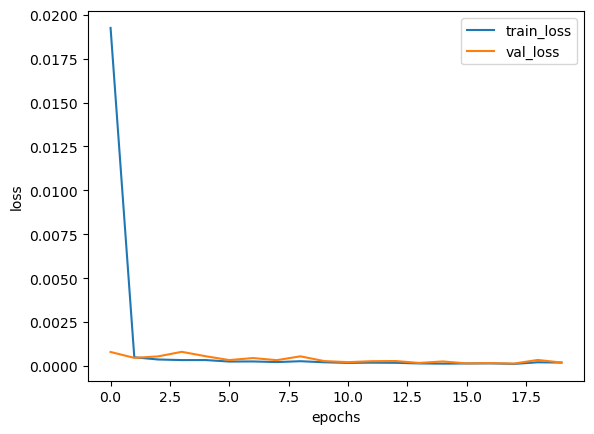

None

========== Prediction process started ==========
8/8 [==============================] - 0s 1ms/step

========== Prediction process completed ==========


In [6]:
plt.plot(tm.history['loss'])
plt.plot(tm.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
print(plt.show())


## using the optimized parameters for making predictions
## The Forward Pass with the test data
print('\n========== Prediction process started ==========') 
Y_predict_normalized = model.predict(X_test)
print('\n========== Prediction process completed ==========')


# Recovering original stock proces from the normalized ones
Y_predict = normalizing.inverse_transform(Y_predict_normalized)
Y_test1 = normalizing.inverse_transform(Y_test.reshape(-1,1))



========= Comparing the predicted and true values =========


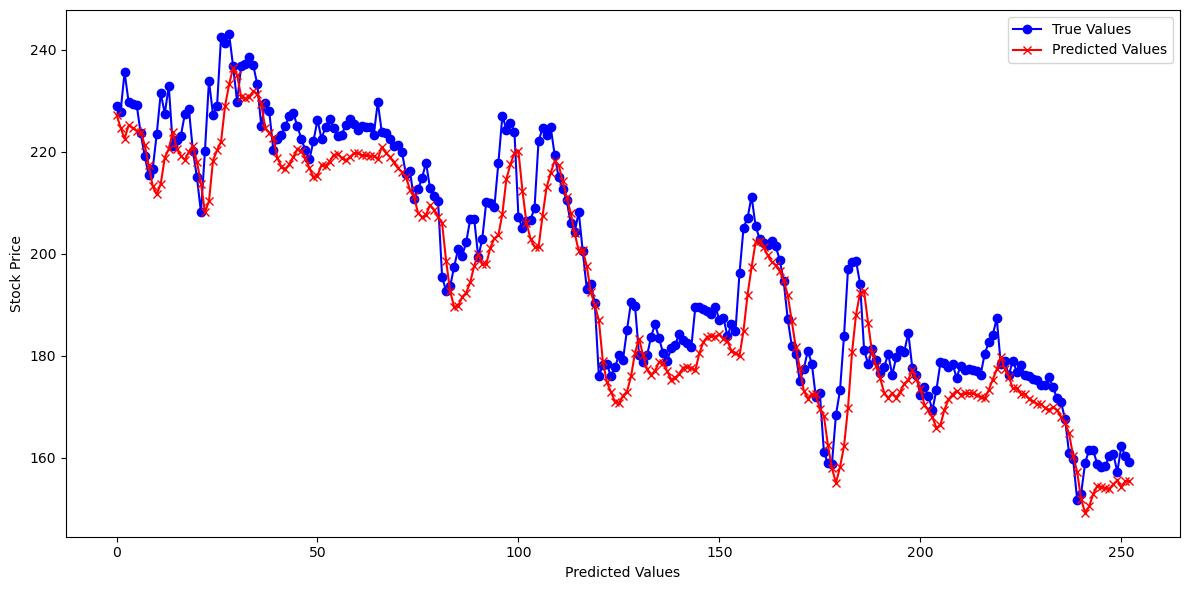

In [7]:
print("\n========= Comparing the predicted and true values =========")
pred_compare(Y_test1, Y_predict)

In [8]:
print("\n======================= Test Errors =======================")
reg_errors(Y_test1, Y_predict)


======================= Test Errors =======================
MAE in the prediction for the test data: 6.070081526564044
RMSE in the prediction for the test data:  7.63111402819343
